This notebook is used to run JAX-CANOAK in US-Hn1 site.

# Load the necessary libraries

In [4]:
# TODO: A more generic way is needed here to load the path
import sys

sys.path.append(
    "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
    # "/global/homes/p/peishi89/jax-watershed/src"
)

In [5]:
import optax
import equinox as eqx

from functools import partial

from math import floor

# import numpy as np
import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import pandas as pd

from jax_canoak.physics.energy_fluxes import get_dispersion_matrix

# from jax_canoak.models import CanoakBaseIFT
from jax_canoak.models import CanoakIFT
from jax_canoak.models import get_canle, update_canle
from jax_canoak.models import get_soilresp, update_soilresp

# from jax_canoak.shared_utilities.optim import perform_optimization
from jax_canoak.shared_utilities.optim import perform_optimization_batch
from jax_canoak.shared_utilities import compute_metrics
from jax_canoak.subjects import convert_met_to_batched_met
from jax_canoak.subjects import (
    # convert_batchedstates_to_states,
    convert_obs_to_batched_obs,
)
from jax_canoak.subjects import get_met_forcings, get_obs, initialize_parameters
from jax_canoak.models import run_canoak_in_batch

# from jax_canoak.models import run_canoak_in_batch_any

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import (
    plot_daily,
    plot_imshow2,
    plot_timeseries_obs_1to1,
    plot_rad,
    plot_ir,
    visualize_tree_diff,
)
from jax_canoak.shared_utilities.plot import (
    plot_obs_1to1,
    plot_obs_comparison,
    plot_obs_energy_closure,
    plot_dij,
    plot_para_sensitivity_ranking,
    plot_le_gs_lai,
    get_time,
)

# from jax_canoak.shared_utilities.plot import plot_veg_temp, plot_dij
# from jax_canoak.shared_utilities.plot import plot_ir, plot_rad, plot_prof2
from jax_canoak.shared_utilities import tune_jax_naninfs_for_debug

jax.config.update("jax_enable_x64", True)
tune_jax_naninfs_for_debug(False)
# jax.config.update("jax_debug_nans", False)
# jax.config.update("jax_debug_infs", False)
# jax.config.update("XLA_PYTHON_CLIENT_ALLOCATOR", 'platform')

%load_ext autoreload
%autoreload 2

# Model parameters and settings

In [6]:
time_zone = -8
latitude = 38.0991538
longitude = -121.49933
stomata = 1
veg_ht = 0.8
leafangle = 1
n_can_layers = 50
n_atmos_layers = 50
meas_ht = 5.0
soil_depth = 0.15
n_hr_per_day = 48
niter = 15
# niter = 1

batch_size = 2
# batch_size = 1274
batch_size = int(74496 / 2)

site = "US-Bi1"
key = "nodl"

# Calibration period
f_forcing = f"../data/fluxtower/{site}/{site}-forcings.csv"
f_obs = f"../data/fluxtower/{site}/{site}-fluxes.csv"

# Test period
f_forcing_test = f"../data/fluxtower/{site}/{site}-forcings-test.csv"
f_obs_test = f"../data/fluxtower/{site}/{site}-fluxes-test.csv"

# Load and set the model forcings

In [7]:
met, n_time = get_met_forcings(f_forcing)
n_batch = floor(n_time / batch_size)
batched_met = convert_met_to_batched_met(met, n_batch, batch_size)

timesteps = get_time(met)

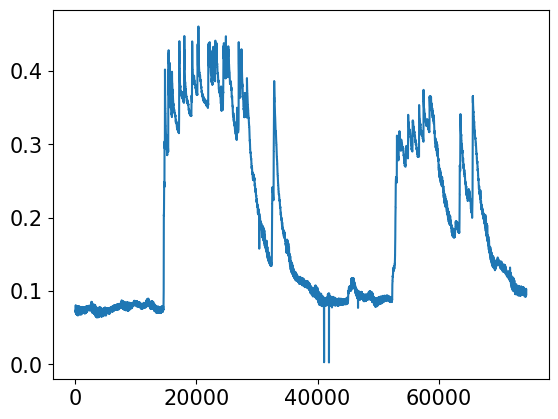

In [8]:
# plt.plot(met.eair_Pa)
# plt.plot(met.es)
# plt.plot(met.lai)
# plt.plot(veg_new.gs)
# plt.plot(met.Tsoil)
plt.plot(met.soilmoisture)

# Load the observations

In [9]:
obs = get_obs(f_obs)

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canoak/subjects/initialization_update.py:270: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  obs.interpolate(method="linear", limit_direction="both", inplace=True)


# Create the model parameter instance

In [10]:
setup, para, para_min, para_max = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    n_atmos_layers=n_atmos_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    obs=obs,
    met=met,
    niter=niter,
    get_para_bounds=True,
)

# Generate or read the dispersion matrix

In [11]:
# dij = get_dispersion_matrix(setup, para)
dij = get_dispersion_matrix(setup, para, f"../data/dij/Dij_{site}.csv")
# import numpy as np
# np.savetxt(f"../../data/dij/Dij_{site}.csv", np.array(dij), delimiter=',')

<Axes: xlabel='Dij [s/m]', ylabel='Height [m]'>

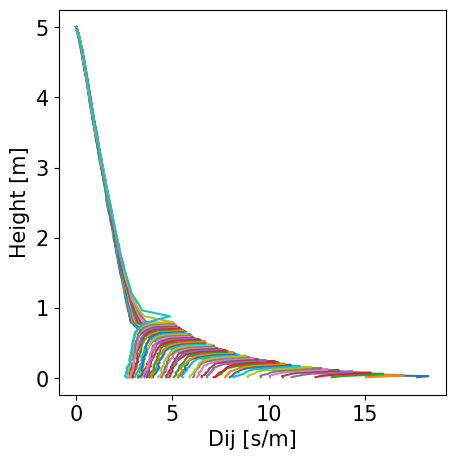

In [12]:
plot_dij(dij, para)

# Run CANOAK!

In [13]:
jax.clear_caches()
canoak_eqx_ift = CanoakIFT(para, setup, dij)
# met, prof, ir, qin, sun, shade, soil, veg, can = canoak_eqx_ift(met)
states, drivers = canoak_eqx_ift(met)
met, prof, ir, qin, sun, shade, soil, veg, can = states
quantum, nir, rnet, sun_ang, leaf_ang, lai = drivers
# met, prof, ir, qin, sun, shade, soil, veg, can = run_canoak_in_batch(batched_met, canoak_eqx_ift)

AttributeError: 'Soil' object has no attribute 'lout_sfc'

/global/homes/p/peishi89/jax-watershed/src/jax_canoak/shared_utilities/plot.py:120: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")


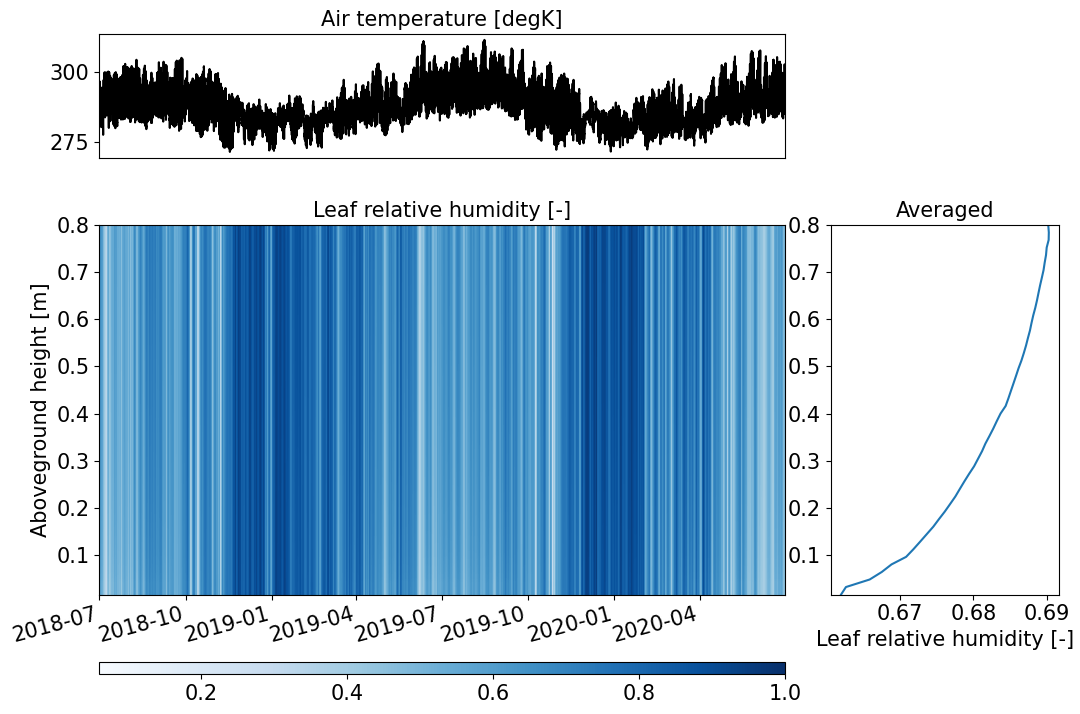

In [ ]:
# Leaf relative humidity
plot_imshow2(
    sun.Leaf_RH.T,
    met,
    para.zht1,
    key="T",
    title="Leaf relative humidity [-]",
    cmap="Blues",
)

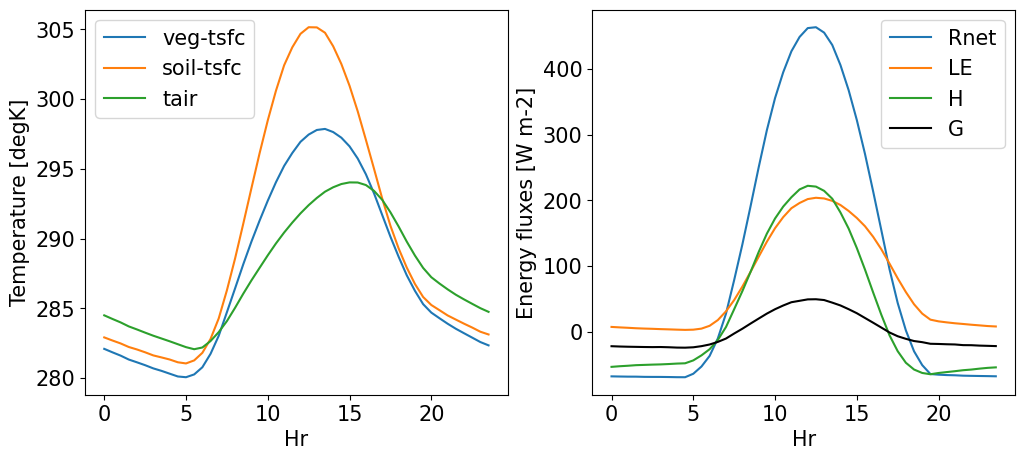

In [ ]:
# Daily average
plot_daily(met, soil, veg, para);

# Save the model

In [14]:
hyperparams = dict(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    n_atmos_layers=n_atmos_layers,
    meas_ht=meas_ht,
    soil_depth=soil_depth,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    niter=niter,
)

In [17]:
from jax_canoak.models import save_model

f_model = f"{site}_{key}_model.eqx"
save_model(f_model, hyperparams, canoak_eqx_ift)

# Load the model

In [20]:
from jax_canoak.models import load_model

canoak_eqx_ift2 = load_model(f_model, CanoakIFT)

In [26]:
assert (
    canoak_eqx_ift.para.RsoilDL.layers[0].weight
    == canoak_eqx_ift2.para.RsoilDL.layers[0].weight
).all()